In [71]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import random
import torch.nn.utils
import textwrap
import re
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
from torchsummary import summary
import torch.nn.functional as F
import tiktoken


In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# file_paths = ['gutenberg_shakespeare.txt', 'gutenberg_war_and_peace.txt', 'gutenberg_don_quixote.txt', 'gutenberg_brothers_karamazov.txt']
file_paths = ['gutenberg_war_and_peace.txt']
# Initialize an empty string to hold the combined content
combined_string = ''

# # Loop through each file path, open the file, read its content, and append it to the combined_string
# for file_path in file_paths:
#     file = open(file_path, 'r', encoding='utf-8-sig')
#     combined_string += file.read().strip()
#     file.close()  # Close the file after reading its content

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        # Read file content, split by lines, strip each line and then join them back
        content = file.read().splitlines()[30:-18500]
        stripped_content = " ".join([line.strip() for line in content if line.strip()])  # Strip leading/trailing whitespace and remove empty lines
        combined_string += stripped_content


# combined_string = re.sub(r'\n\s*\n', '\n', combined_string)
#combined_string = re.sub(r"[\n\t]*", "", combined_string)

unique_chars = list(set(combined_string))
# print(unique_chars)
m = len(unique_chars)
print(m)

99


In [73]:
encoding = tiktoken.get_encoding("r50k_base")

In [74]:
# input_feature_dim = m
input_feature_dim = 50257
# hidden_size = m*3
hidden_size = 2048

In [75]:
def tokenize(sequence):
    character_indices = []
    for i in sequence:
        char_index = unique_chars.index(i)
        character_indices.append(char_index)
    return character_indices


In [76]:
class TransformerModel(nn.Module):
    def __init__(self, input_feature_dim, d_model, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_feature_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, input_feature_dim)
        self.pos_encoder = PositionalEncoding(d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = self.generate_square_subsequent_mask(len(x)).to(device)
        x = self.transformer(x, mask)
        x = self.fc(x)
        return x
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + (self.pe[:x.size(0)]).squeeze()
        return x

In [77]:
num_heads = 8
num_layers = 6
transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
# transformer_model = TransformerModel(input_feature_dim, int(input_feature_dim/2) - (int(input_feature_dim/2) % 4)).to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr = 0.0001)
# scheduler = MultiStepLR(optimizer, milestones=[2500, 7000], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
train_temperature = 1.0


In [78]:
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

In [79]:
# print(summary(transformer_model, (1,m)))
pytorch_total_params = sum(p.numel() for p in transformer_model.parameters())
print(pytorch_total_params)


9464259


In [80]:
batch_size = 250
batches = [combined_string[i:i+batch_size] for i in range(0, len(combined_string), batch_size)]
if len(batches[-1]) != batch_size:
    batches.pop()

In [81]:
num_epochs = 2
training_loss_values = []
training_error_values = []
validation_loss_values = []
validation_error_values = []
x_vals = []
x_val = 1
validation_x_vals = []
num_validation_seq = 5

for epoch in range(num_epochs):

    loss_accumulator = 0
    error_accumulator = 0
    
    for i,input in enumerate(batches):
        transformer_model.train()
        tokens = encoding.encode(input)
        sequence = torch.tensor(tokens).long().to(device)
        labels = sequence[1:]
        output = transformer_model(sequence[:-1])
        # loss = criterion(output,labels)
        softmaxed_logits = softmax_with_temperature(output, train_temperature)
        loss = nn.NLLLoss()(torch.log(softmaxed_logits), labels)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 15.0)
        loss_accumulator += loss.item()
        optimizer.step()
        # training_loss_values.append(loss.item())
        
        predicted_labels = torch.argmax(output,dim=1)
        training_error = 1.0 - (labels == predicted_labels).sum()/(len(sequence)-1)
        # training_error_values.append(training_error.item())
        error_accumulator += training_error.item()

        # x_vals.append(x_val)

        if x_val % 50 == 0:  # If 50 iterations have passed
            avg_loss = loss_accumulator / 50.0
            avg_error = error_accumulator / 50.0
            training_loss_values.append(avg_loss)
            training_error_values.append(avg_error)
            x_vals.append(x_val)
            # Reset the accumulators
            loss_accumulator = 0
            error_accumulator = 0

        if (x_val % 1000) == 0:
            transformer_model.eval()
            print('Iteration: {}/{}'.format(x_val, len(batches)))

            test_loss_accumulator = 0
            test_error_accumulator = 0
            
            # Validation
            for j in range(num_validation_seq):
                future_input = batches[i+j+1]
                future_tokens = encoding.encode(future_input)
                future_sequence = torch.tensor(future_tokens).long().to(device)
                future_output = transformer_model(future_sequence[:-1])
                future_labels = future_sequence[1:]
                # future_loss = criterion(future_output, future_labels)
                future_softmaxed_logits = softmax_with_temperature(future_output, train_temperature)
                future_loss = nn.NLLLoss()(torch.log(future_softmaxed_logits), future_labels)
                # validation_loss_values.append(future_loss.item())
                test_loss_accumulator += future_loss.item()
                future_predicted_labels = torch.argmax(future_output, dim=1)
                validation_error = (1.0 - (future_labels == future_predicted_labels).sum() / (len(future_sequence) - 1)).item()
                # validation_error_values.append(validation_error.item())
                test_error_accumulator += validation_error
            validation_loss_values.append((test_loss_accumulator/num_validation_seq))
            validation_error_values.append((test_error_accumulator/num_validation_seq))
            validation_x_vals.append(x_val)
            
        x_val +=1
        # scheduler.step()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


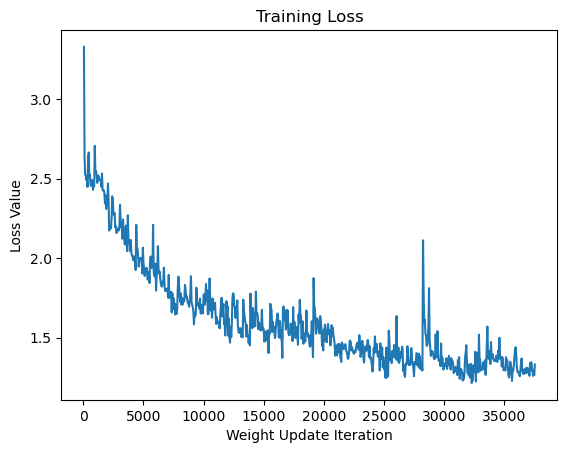

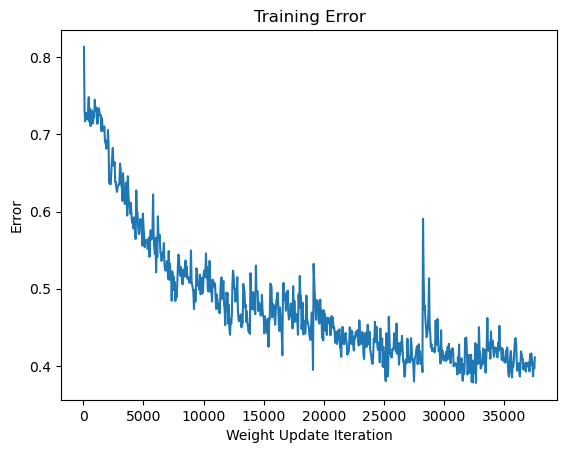

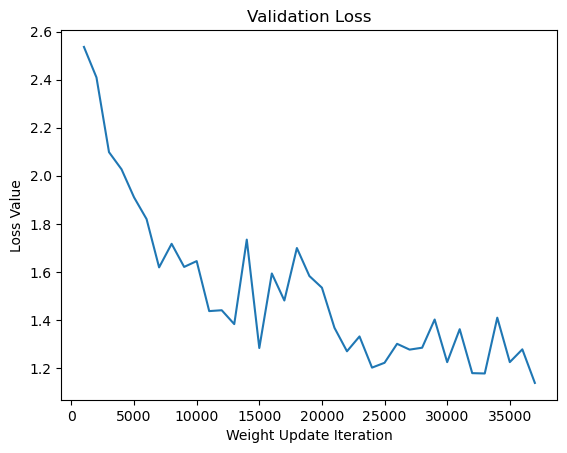

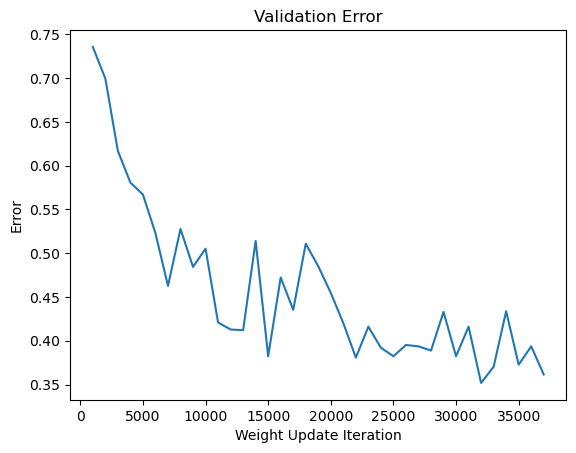

In [ ]:
# output,_ = rnn(input[40].to(device))
# output = [unique_chars[i] for i in torch.argmax(output, dim=1).tolist()]
# output = torch.tensor(unique_chars)
# [torch.argmax(output, dim=1)]
# print(batches[40])
# # print((output))
# # print(output)
# print(error)
# print(current_labels)
# print(torch.argmax(output,dim=1))
# test = [1,2,3,4,5]

# training_error_values = [i.cpu().item() for i in training_error_values]
# validation_error_values = [i.cpu().item() for i in validation_error_values]
# validation_loss_values = [i.cpu().item() for i in validation_loss_values]


plt.figure()
plt.plot(x_vals,training_loss_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Training Loss')
plt.figure()
plt.plot(x_vals, training_error_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Training Error')
plt.figure()
plt.plot(validation_x_vals, validation_loss_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Validation Loss')
plt.figure()
plt.plot(validation_x_vals, validation_error_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Validation Error')
plt.show()

In [ ]:
test_temperature = 0.5
transformer_model.eval()
capital_letters = [chr(i) for i in range(65, 91)]
example_sentences = []
initialize = ["A silent whisper", "Over the horizon", "Beneath the star", "Waves crashed on", "In the deep void"]
for i in range(5):
    sentence = initialize[i]
    tokenized_sentence = encoding.encode(sentence)
    next_char = torch.tensor(tokenized_sentence).long().to(device)
    for j in range(250-16):
        next_char = transformer_model(next_char)
        next_softmax = softmax_with_temperature(next_char, test_temperature)
        # predicted_char = torch.argmax(next_softmax,dim=1)
        predicted_char = torch.multinomial(next_softmax,1)
        # letter = unique_chars[predicted_char[-1]]
        letter = encoding.decode[predicted_char[-1]]
        sentence += letter
        # next_char = torch.tensor(tokenize(sentence)).long().to(device)
        next_tokenized_sentence = encoding.encode(sentence)
        next_char = torch.tensor(next_tokenized_sentence).long().to(device)
    example_sentences.append(sentence)
example_sentences = np.array(example_sentences)
print(example_sentences)

['A silent whispered at the troubles. The same shudden of his small for his eye. And he was larged for Mitya, of the tombs of the conscience. “Probed could have it for them.. The brand the perchant rich?” “Misha!” “I thought now start, there’s a fist c'
 'Over the horizon, for fine both the room. My sight of Mitya had been dispised into his hand and waiting in me, for he had been the gate. It was an old man in his face was so that as he had found to give his face the night. The bottle show for him a h'
 'Beneath the start! I fell almost three thousand, then, and the same in it of sool greety. I was being one, he saying to me. Here was disgrace of that, there woman in my face and the hour. But it’s marred not the pay to me of sible and some one hand t'
 'Waves crashed on the money. “That’s a character, go!” the same one and satisfied, and afterwards, at last him as too pocket. “That’s not you’d save all come to me to go to life from my brothers.” He had been come to his own in the money